In [1]:
## 一般設定

verbose   = False
save_data = False

## 分野の設定
domains = { 'medical'    : True,
            'mce'        : False,
            'economic'   : True,
            'juridical'  : True,
            'publishing' : True }

target_vars = ['word']
target_vars.extend(domains.keys())
print(f"target_vars: {target_vars}")

## 分野の選択
selected_domains = { k:v for k,v in domains.items() if v == True } # as dictionary
print(f"selected domains: {[ k for k, v in selected_domains.items() if v == True ]}")

## domain count balancing
balanced = True
print(f"domain balancing: {balanced}")

target_vars: ['word', 'medical', 'mce', 'economic', 'juridical', 'publishing']
selected domains: ['medical', 'economic', 'juridical', 'publishing']
domain balancing: True


In [2]:
### LDA

import random
random.seed(12345)

## n_topics
n_topics = 5

## doc, term の設定
doc_type           = 'word'
term_size          = 'character'
term_types         = [ '1gram', '2gram', '3gram', 'skippy2gram', 'skippy3gram' ]
term_type          = term_types[2]
ngram_is_inclusive = True
max_doc_length     = 12

## DTM 濾過のための設定
minfreq_val = 3
abuse_threshold_val = 0.03

In [3]:
## colormap
colormap =  [ 'deeppink', 'pink',  'orange', 'green', 'paleturquoise', 'wheat' ]
for d, c in zip(domains, colormap):
    print(f"分野 {d}".ljust(16) + ": " + f"色 {c}")

分野 medical      : 色 deeppink
分野 mce          : 色 pink
分野 economic     : 色 orange
分野 juridical    : 色 green
分野 publishing   : 色 paleturquoise


In [4]:
import sys, os, copy, pickle
import numpy as np
import pandas as pd

# データの準備

In [5]:
## 保存してあるデータの読み込み

target_dir = "saves"
files = [ f for f in os.listdir(target_dir) if f.endswith(".p") or f.endswith(".dump") ]
#print(files)
#target_file = files[-3] # selects a target file
target_file = "mixed-terms-filtered-2024-01-03-15.p" # publishing x sampled=1
print(f"target file: {target_file}")
target_file_name = os.path.join(target_dir, target_file)

target file: mixed-terms-filtered-2024-01-03-15.p


In [6]:
## Pandas を使って .csv ファイルを開くと実は面倒
#import pandas as pd
#df = pd.read_csv(target_file_name, quotechar='"') ## pandas.csv_read(..) opens a file directly
#df

In [7]:
import pandas as pd
import pickle
with open(target_file_name, 'rb') as pickled:
    df = pickle.load(pickled)
df

word  medical  mce  economic  juridical  publishing  domain  \
727          審問      0.0  0.0       0.0        1.0         0.0       3   
332         後頭葉      1.0  0.0       0.0        0.0         0.0       0   
435        ISBN      0.0  0.0       0.0        0.0         1.0       4   
1224       腸管癒着      1.0  0.0       0.0        0.0         0.0       0   
577        前方脱臼      1.0  0.0       0.0        0.0         0.0       0   
...         ...      ...  ...       ...        ...         ...     ...   
68          婚姻届      0.0  0.0       0.0        1.0         0.0       3   
103   ジャパンバッシング      0.0  0.0       1.0        0.0         0.0       2   
1307       胸骨挫傷      1.0  0.0       0.0        0.0         0.0       0   
2279      麻痺性歩行      1.0  0.0       0.0        0.0         0.0       0   
154         買掛金      0.0  0.0       0.0        1.0         0.0       3   

                            1gram  \
727                        [審, 問]   
332                     [後, 頭, 葉]   
435                  [I, S, B, N]   
1224                 [腸, 管, 癒, 着]   
577                  [前, 方, 脱, 臼]   
...                           ...   
68                      [婚, 姻, 届]   
103   [ジ, ャ, パ, ン, バ, ッ, シ, ン, グ]   
1307                 [胸, 骨, 挫, 傷]   
2279              [麻, 痺, 性, 歩, 行]   
154                     [買, 掛, 金]   

                                                  2gram  \
727                                          [審問, 審, 問]   
332                                   [後頭, 頭葉, 後, 頭, 葉]   
435                            [IS, SB, BN, I, S, B, N]   
1224                           [腸管, 管癒, 癒着, 腸, 管, 癒, 着]   
577                            [前方, 方脱, 脱臼, 前, 方, 脱, 臼]   
...                                                 ...   
68                                    [婚姻, 姻届, 婚, 姻, 届]   
103   [ジャ, ャパ, パン, ンバ, バッ, ッシ, シン, ング, ジ, ャ, パ, ン, バ...   
1307                           [胸骨, 骨挫, 挫傷, 胸, 骨, 挫, 傷]   
2279                    [麻痺, 痺性, 性歩, 歩行, 麻, 痺, 性, 歩, 行]   
154                                   [買掛, 掛金, 買, 掛, 金]   

                                                  3gram  \
727                                      [審問, 審問, 審, 問]   
332                              [後頭葉, 後頭, 頭葉, 後, 頭, 葉]   
435                  [ISB, SBN, IS, SB, BN, I, S, B, N]   
1224                 [腸管癒, 管癒着, 腸管, 管癒, 癒着, 腸, 管, 癒, 着]   
577                  [前方脱, 方脱臼, 前方, 方脱, 脱臼, 前, 方, 脱, 臼]   
...                                                 ...   
68                               [婚姻届, 婚姻, 姻届, 婚, 姻, 届]   
103   [ジャパ, ャパン, パンバ, ンバッ, バッシ, ッシン, シング, ジャ, ャパ, パン...   
1307                 [胸骨挫, 骨挫傷, 胸骨, 骨挫, 挫傷, 胸, 骨, 挫, 傷]   
2279     [麻痺性, 痺性歩, 性歩行, 麻痺, 痺性, 性歩, 歩行, 麻, 痺, 性, 歩, 行]   
154                              [買掛金, 買掛, 掛金, 買, 掛, 金]   

                                            skippy2gram  \
727                                          [審問, 審, 問]   
332                              [後頭, 後…葉, 頭葉, 後, 頭, 葉]   
435             [IS, I…B, I…N, SB, S…N, BN, I, S, B, N]   
1224            [腸管, 腸…癒, 腸…着, 管癒, 管…着, 癒着, 腸, 管, 癒, 着]   
577             [前方, 前…脱, 前…臼, 方脱, 方…臼, 脱臼, 前, 方, 脱, 臼]   
...                                                 ...   
68                               [婚姻, 婚…届, 姻届, 婚, 姻, 届]   
103   [ジャ, ジ…パ, ジ…ン, ジ…バ, ジ…ッ, ジ…シ, ジ…グ, ャパ, ャ…ン, ャ…...   
1307            [胸骨, 胸…挫, 胸…傷, 骨挫, 骨…傷, 挫傷, 胸, 骨, 挫, 傷]   
2279  [麻痺, 麻…性, 麻…歩, 麻…行, 痺性, 痺…歩, 痺…行, 性歩, 性…行, 歩行,...   
154                              [買掛, 買…金, 掛金, 買, 掛, 金]   

                                            skippy3gram  
727                                      [審問, 審問, 審, 問]  
332                         [後頭葉, 後頭, 後…葉, 頭葉, 後, 頭, 葉]  
435   [ISB, IS…N, I…BN, SBN, IS, I…B, I…N, SB, S…N, ...  
1224  [腸管癒, 腸管…着, 腸…癒着, 管癒着, 腸管, 腸…癒, 腸…着, 管癒, 管…着, ...  
577   [前方脱, 前方…臼, 前…脱臼, 方脱臼, 前方, 前…脱, 前…臼, 方脱, 方…臼, ...  
...                                                 ...  
68                          [婚姻届, 婚姻, 婚…届, 姻届, 婚, 姻, 届]  
103   [ジャパ, ジャ…ン, ジャ…バ, ジャ…ッ, ジャ…シ, ジャ…グ, ジ…パン, ジ…パ…...  
1307  [胸骨挫, 胸骨…傷, 胸…挫傷, 骨挫傷,

In [8]:
## 列名 domain を変更し，文字列としての domain を追加
df = df.rename(columns = {'domain': 'domain_id'})
df['domain'] = [ list(domains.keys())[i] for i in df['domain_id'] ]
df

word  medical  mce  economic  juridical  publishing  domain_id  \
727          審問      0.0  0.0       0.0        1.0         0.0          3   
332         後頭葉      1.0  0.0       0.0        0.0         0.0          0   
435        ISBN      0.0  0.0       0.0        0.0         1.0          4   
1224       腸管癒着      1.0  0.0       0.0        0.0         0.0          0   
577        前方脱臼      1.0  0.0       0.0        0.0         0.0          0   
...         ...      ...  ...       ...        ...         ...        ...   
68          婚姻届      0.0  0.0       0.0        1.0         0.0          3   
103   ジャパンバッシング      0.0  0.0       1.0        0.0         0.0          2   
1307       胸骨挫傷      1.0  0.0       0.0        0.0         0.0          0   
2279      麻痺性歩行      1.0  0.0       0.0        0.0         0.0          0   
154         買掛金      0.0  0.0       0.0        1.0         0.0          3   

                            1gram  \
727                        [審, 問]   
332                     [後, 頭, 葉]   
435                  [I, S, B, N]   
1224                 [腸, 管, 癒, 着]   
577                  [前, 方, 脱, 臼]   
...                           ...   
68                      [婚, 姻, 届]   
103   [ジ, ャ, パ, ン, バ, ッ, シ, ン, グ]   
1307                 [胸, 骨, 挫, 傷]   
2279              [麻, 痺, 性, 歩, 行]   
154                     [買, 掛, 金]   

                                                  2gram  \
727                                          [審問, 審, 問]   
332                                   [後頭, 頭葉, 後, 頭, 葉]   
435                            [IS, SB, BN, I, S, B, N]   
1224                           [腸管, 管癒, 癒着, 腸, 管, 癒, 着]   
577                            [前方, 方脱, 脱臼, 前, 方, 脱, 臼]   
...                                                 ...   
68                                    [婚姻, 姻届, 婚, 姻, 届]   
103   [ジャ, ャパ, パン, ンバ, バッ, ッシ, シン, ング, ジ, ャ, パ, ン, バ...   
1307                           [胸骨, 骨挫, 挫傷, 胸, 骨, 挫, 傷]   
2279                    [麻痺, 痺性, 性歩, 歩行, 麻, 痺, 性, 歩, 行]   
154                                   [買掛, 掛金, 買, 掛, 金]   

                                                  3gram  \
727                                      [審問, 審問, 審, 問]   
332                              [後頭葉, 後頭, 頭葉, 後, 頭, 葉]   
435                  [ISB, SBN, IS, SB, BN, I, S, B, N]   
1224                 [腸管癒, 管癒着, 腸管, 管癒, 癒着, 腸, 管, 癒, 着]   
577                  [前方脱, 方脱臼, 前方, 方脱, 脱臼, 前, 方, 脱, 臼]   
...                                                 ...   
68                               [婚姻届, 婚姻, 姻届, 婚, 姻, 届]   
103   [ジャパ, ャパン, パンバ, ンバッ, バッシ, ッシン, シング, ジャ, ャパ, パン...   
1307                 [胸骨挫, 骨挫傷, 胸骨, 骨挫, 挫傷, 胸, 骨, 挫, 傷]   
2279     [麻痺性, 痺性歩, 性歩行, 麻痺, 痺性, 性歩, 歩行, 麻, 痺, 性, 歩, 行]   
154                              [買掛金, 買掛, 掛金, 買, 掛, 金]   

                                            skippy2gram  \
727                                          [審問, 審, 問]   
332                              [後頭, 後…葉, 頭葉, 後, 頭, 葉]   
435             [IS, I…B, I…N, SB, S…N, BN, I, S, B, N]   
1224            [腸管, 腸…癒, 腸…着, 管癒, 管…着, 癒着, 腸, 管, 癒, 着]   
577             [前方, 前…脱, 前…臼, 方脱, 方…臼, 脱臼, 前, 方, 脱, 臼]   
...                                                 ...   
68                               [婚姻, 婚…届, 姻届, 婚, 姻, 届]   
103   [ジャ, ジ…パ, ジ…ン, ジ…バ, ジ…ッ, ジ…シ, ジ…グ, ャパ, ャ…ン, ャ…...   
1307            [胸骨, 胸…挫, 胸…傷, 骨挫, 骨…傷, 挫傷, 胸, 骨, 挫, 傷]   
2279  [麻痺, 麻…性, 麻…歩, 麻…行, 痺性, 痺…歩, 痺…行, 性歩, 性…行, 歩行,...   
154                              [買掛, 買…金, 掛金, 買, 掛, 金]   

                                            skippy3gram      domain  
727                                      [審問, 審問, 審, 問]   juridical  
332                         [後頭葉, 後頭, 後…葉, 頭葉, 後, 頭, 葉]     medical  
435   [ISB, IS…N, I…BN, SBN, IS, I…B, I…N, SB, S…N, ...  publishing  
1224  [腸管癒, 腸管…着, 腸…癒着, 管癒着, 腸管, 腸…癒, 腸…着, 管癒, 管…着, ...     medical  
577   [前方脱, 前方…臼, 前…脱臼, 方脱臼, 前方, 前…脱, 前…臼, 方脱, 方…臼, ...     medical  
...                                                 ...         ...  
68                      

In [9]:
## diction = dtm を構築

bots = df[term_type] # bot = bag-of-terms

from gensim.corpora.dictionary import Dictionary
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<9465 unique tokens: ['問', '審', '審問', '後', '後頭']...>


In [10]:
## diction の濾過

import copy
diction_copy = copy.deepcopy(diction) # 予備の生成

## 対象とする語の最低頻度: documents の数が少ない場合は小さくても良い
print(f"minfreq_val: {minfreq_val}")

## 過剰使用 term の濾過
print(f"abuse_threshold_val: {abuse_threshold_val}")

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = minfreq_val, no_above = abuse_threshold_val)

## check
print(diction_copy) # 中身を見るには print(..) が必要

minfreq_val: 3
abuse_threshold_val: 0.03
Dictionary<1589 unique tokens: ['問', '審', '後', '後頭', '葉']...>


In [11]:
### gensim の用 corpusの構築

## データを選択
diction = diction_copy # 名前を元に戻す

## corpus構築
corpus = [ diction.doc2bow(bot) for bot in bots ]

print(f"Number of documents: {len(corpus)}")

Number of documents: 1997


In [12]:
## LDA モデルの構築

from gensim.models import LdaModel

## LDAモデル
lda = LdaModel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)

print(lda) # 中身を見るには print(..) が必要

LdaModel<num_terms=1589, num_topics=5, decay=0.5, chunksize=2000>


In [13]:
%%capture --no-display

## lda のtopic ごとに，関連度の高い term を表示
#
import pandas as pd

n_terms = 20 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

topic 1 topic 2 topic 3 topic 4 topic 5
0        人       産       腫       法       ル
1        金       イ       リ       炎       金
2        業       保       瘍       本       ド
3        国       機      腫瘍       会       判
4        紙       紙       ク       資       紙
5        ラ       者       傷       動       レ
6        理       株       権       腫       裁
7        管       中       機       傷       業
8        合       症       経       産       フ
9        貼       事       不       経       ア
10       P       制       出       ア       行
11       ク       資       ル       耳      裁判
12       ア       人       血       生       定
13       制       取       済       プ       会
14       録      請求      経済       事       シ
15      登録       請       膜       血       バ
16       登       炎       子       所      ンド
17       ロ       大       紙      先天       炎
18       行       本       タ     先天性       イ
19       テ       求       シ       先       症

In [14]:
%%capture --no-display

## pyLDAvis を使った結果 LDA の可視化: 階層クラスタリングより詳しい

import pyLDAvis
installed_version = pyLDAvis.__version__
print(f"pyLDAvis installed version: {installed_version}")

if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()

#
lda_used     = lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター
use_tSNE = False
if use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne', n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)

## 結果について
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [15]:
## documents のエンコード

print(f"get encodings using term_type: {term_type}")

check = False
encoding = [ ]
for i, row in df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc: {enc}")
    encoding.append(enc)
#
len(encoding)

get encodings using term_type: 3gram


1997

In [16]:
random.sample(encoding, 3)

[[(0, 0.0016534978),
  (1, 0.0016534978),
  (2, 0.32967377),
  (3, 0.66536576),
  (4, 0.0016534978)],
 [(0, 0.9868842),
  (1, 0.003278958),
  (2, 0.003278958),
  (3, 0.003278958),
  (4, 0.003278958)],
 [(0, 0.002469227),
  (1, 0.9901231),
  (2, 0.002469227),
  (3, 0.002469227),
  (4, 0.002469227)]]

In [17]:
## df に encoding の列を追加: tuple なので map(..) が必要
df['enc'] = [ list(map(lambda x: x[1], enc)) for enc in encoding ]
if check:
    df

# t-SNE を使った可視化

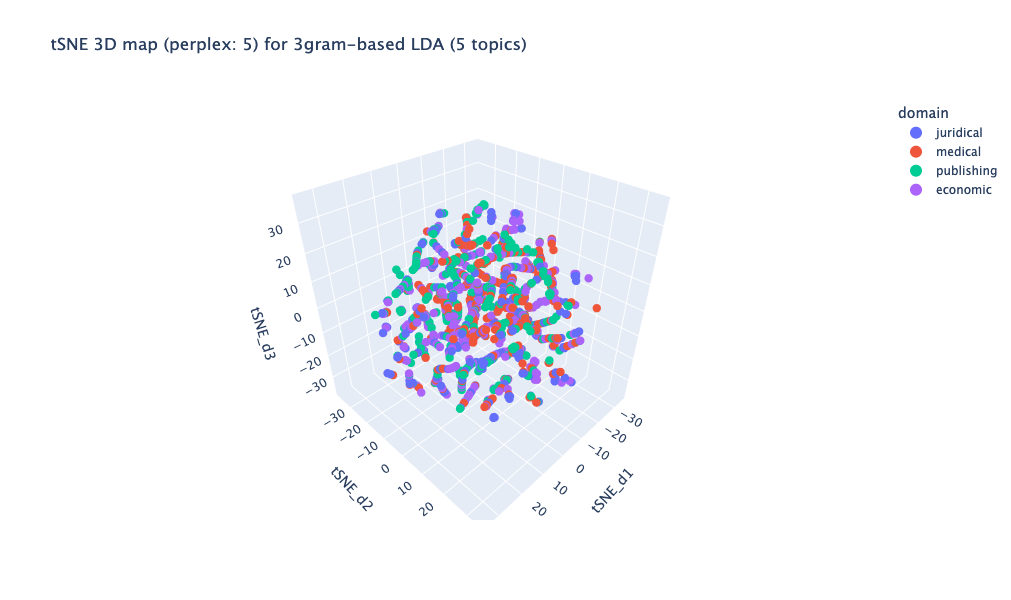

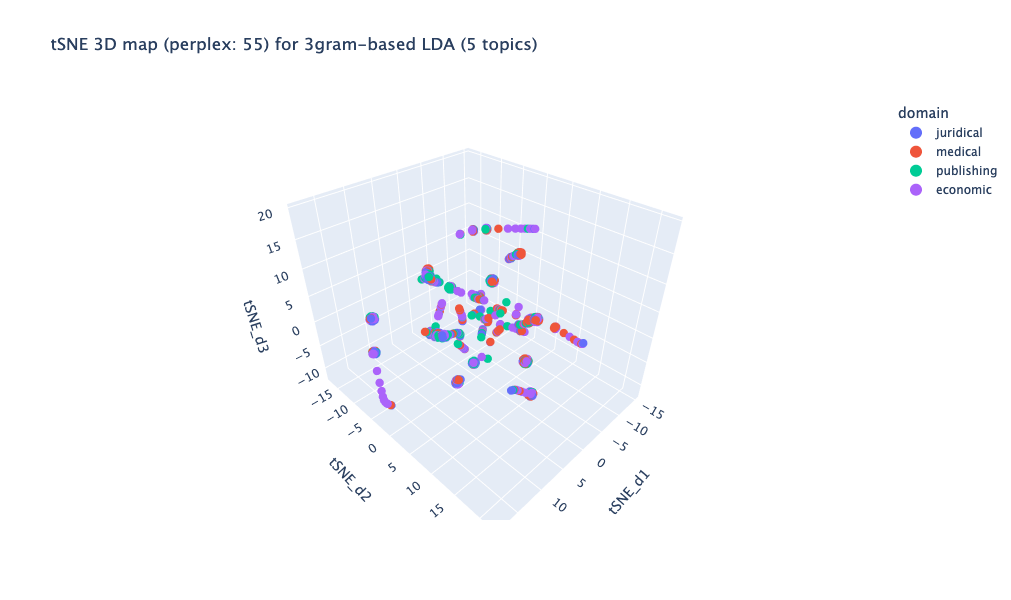

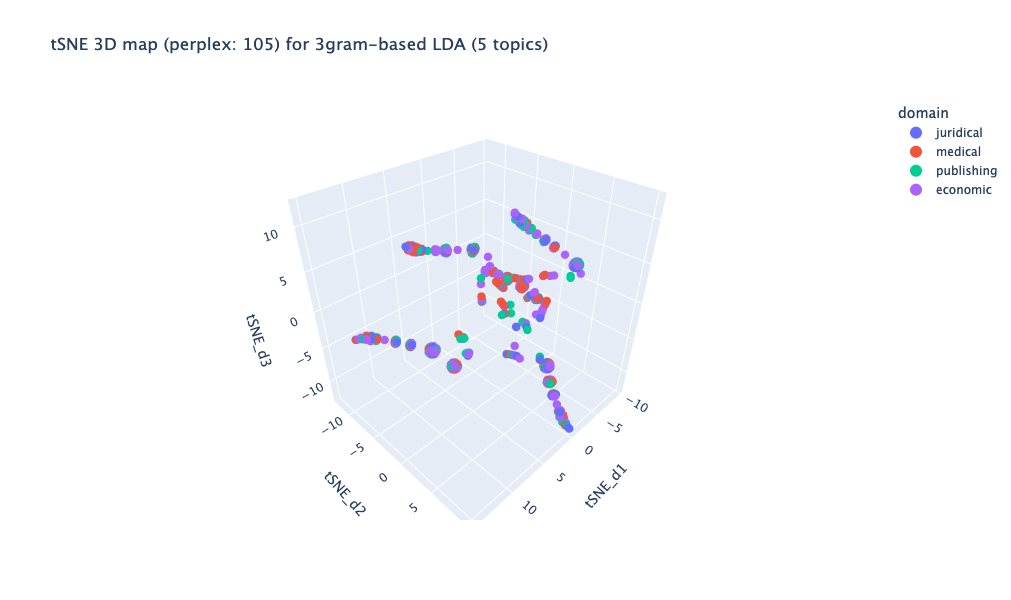

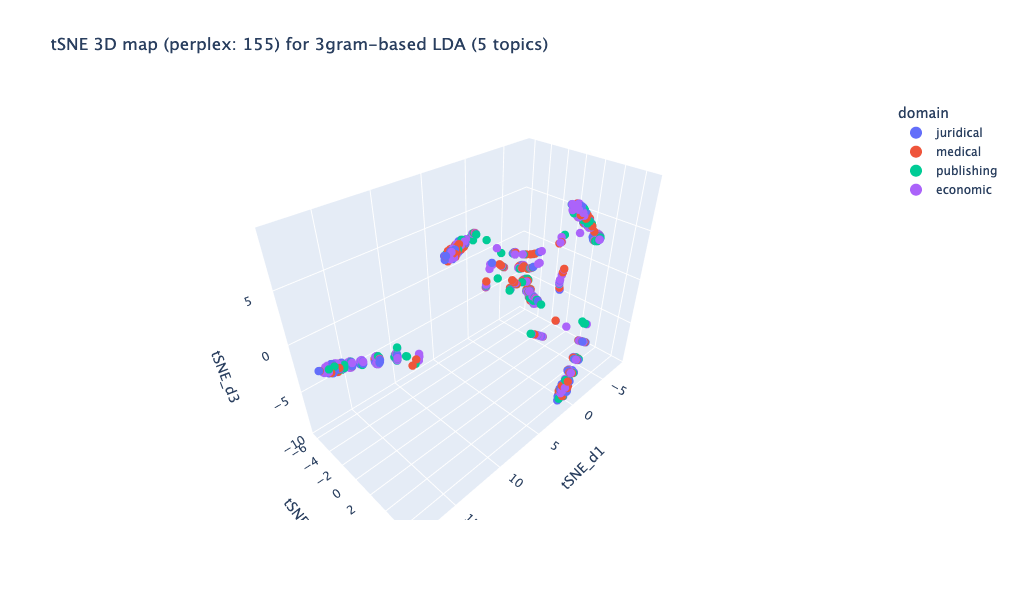

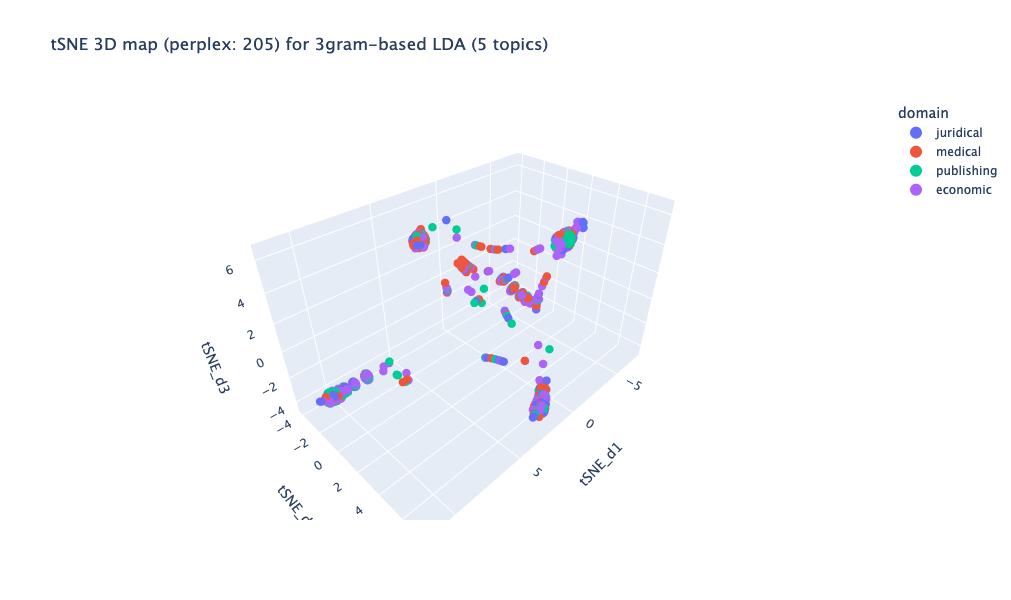

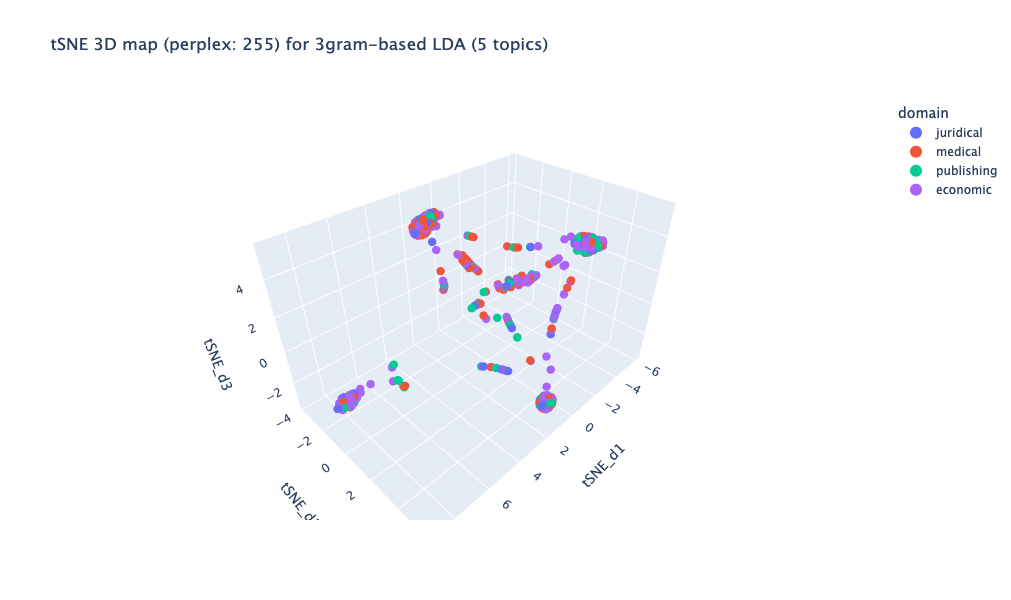

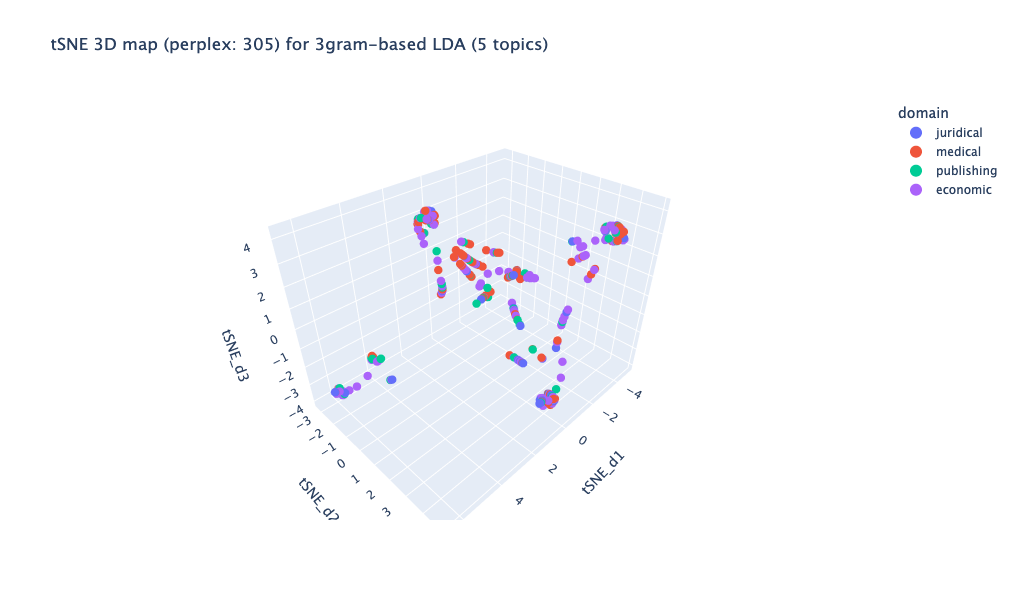

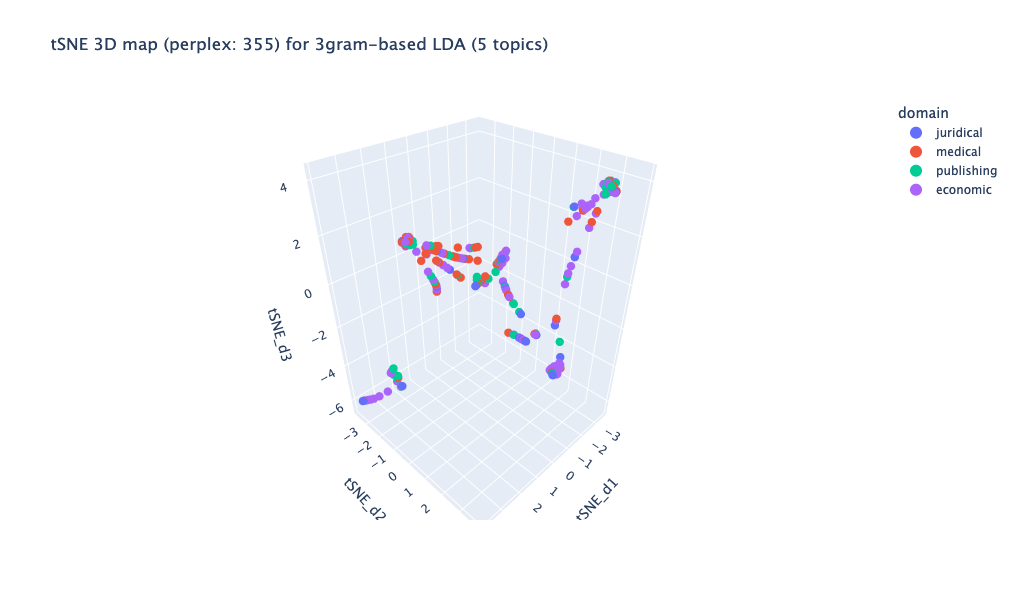

In [18]:
%%capture --no-display

## Plotlyを使って tSNE の結果の可視化 (3D)

import sklearn.manifold
import numpy as np
import pandas as pd
import plotly.express as pex

## perplexity の効果を確認
divider = 5
relative_perplexity = True
if relative_perplexity:
    max_val = round(len(df)/divider)
else:
    max_val = 200
perplexity_vals = range(5, max_val, 50) # 10から始めて doc数の 1/divider まで，50づつ大きくする
print(f"perplexity vals: {perplexity_vals}")

E = np.array(list(df['enc']))
for perplexity_val in perplexity_vals:
    ## tSNE 3D の生成
    tSNE_3d_varied = sklearn.manifold.TSNE(n_components = 3, random_state = 0,
                                perplexity = perplexity_val, n_iter = 1000)
    ## Fitting
    model_fitted = tSNE_3d_varied.fit_transform(E)
    
    ## df の編集
    df['tSNE_d1'] = model_fitted[:,0]
    df['tSNE_d2'] = model_fitted[:,1]
    df['tSNE_d3'] = model_fitted[:,2]
    
    ## 描画
    title_val = f"tSNE 3D map (perplex: {perplexity_val}) for {term_type}-based LDA ({n_topics} topics)"
    fig = pex.scatter_3d(df, x = 'tSNE_d1', y = 'tSNE_d2', z = 'tSNE_d3',
                                     color = 'domain', title = title_val)
    #
    fig.update_layout(showlegend = True, legend = {'itemsizing': 'constant'},
                  autosize = False, width = 600, height = 600)
    fig.update_traces(marker_size = 5)
    fig.show()
#

# 階層クラスタリング

In [19]:
## 階層クラスタリングのための事例サンプリング

import os, pickle

## データの再利用のための設定
target_dir = "saves"
signature  = "hc-df-sampled-"
        
## サンプリング処理

reload_df_sampled = True
save_a_new_df     = False # データを更新する時に True にする

## df-sampled.p の最新の版を選ぶ
target_p_fname = [ f for f in [ f for f in os.listdir(target_dir)
                               if signature in str(f) ] if f.endswith(".p") or f.endswith(".dump") ][-1]
print(f"target_p_fname: {target_p_fname}")

target_p_fpath = os.path.join(target_dir, target_p_fname)
with open(target_p_fpath, 'rb') as data:
    print(f"loading pickle: {target_p_fpath}")
    df_sampled_reloaded = pickle.load(data)

##
df_size = len(df)
hc_sampling_rate = 0.1 # 変更可能: 大きくし過ぎると図が見にくい

if reload_df_sampled:
    df_sampled = df_sampled_reloaded
else:
    df_sampled = df.sample(round(df_size * hc_sampling_rate))
    ## 保存
    if save_a_new_df:
        import datetime as dt
        ct = dt.datetime.now()
        ## Pandas で .csv として
        hc_sample_fn1 = f"{target_dir}/{signature}{ct.date()}-{str(ct.time())[:2]}" + ".csv"
        ## pickle を .p として
        hc_sample_fn2 = f"{target_dir}/{signature}{ct.date()}-{str(ct.time())[:2]}" + ".p"

        ## reload 用に保存
        import pandas as pd
        df_sampled.to_csv(hc_sample_fn1)
        print(f"saving data to {hc_sample_fn1}")

        ## pickle.dump(..)で
        import pickle
        print(f"saving data to {hc_sample_fn2}")
        with open(hc_sample_fn2, "wb") as f:
            pickle.dump(df_sampled, f)

##
print(f"{len(df_sampled)} rows are sampled (preservation rate: {len(df_sampled)/df_size})")

## domain 事例数の確認
df_sampled['domain'].value_counts()

target_p_fname: hc-df-sampled-2024-01-08-18.p
loading pickle: saves/hc-df-sampled-2024-01-08-18.p
200 rows are sampled (preservation rate: 0.100150225338007)


domain
juridical     55
publishing    53
medical       52
economic      40
Name: count, dtype: int64

In [20]:
df_sampled.columns

Index(['word', 'medical', 'mce', 'economic', 'juridical', 'publishing',
       'domain_id', '1gram', '2gram', '3gram', 'skippy2gram', 'skippy3gram',
       'domain', 'enc', 'tSNE_dim1', 'tSNE_dim2', 'tSNE_dim3', 'tSNE_d1',
       'tSNE_d2', 'tSNE_d3'],
      dtype='object')

In [21]:
# df_sampled['enc'] の再エンコード

print(f"get encodings using term_type: {term_type}")

check = False
re_encoding = [ ]
for i, row in df_sampled.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc: {enc}")
    re_encoding.append(enc)
#
len(re_encoding)

get encodings using term_type: 3gram


200

In [22]:
## 値の更新

df_sampled['enc'] = [ enc[-1] for enc in re_encoding ]
df_sampled

word  medical  mce  economic  juridical  publishing  domain_id  \
423   経済協力開発機構      0.0  0.0       1.0        0.0         0.0          2   
288      無償の供与      0.0  0.0       0.0        1.0         0.0          3   
1583     解離性痙攣      1.0  0.0       0.0        0.0         0.0          0   
186         法律      0.0  0.0       0.0        1.0         0.0          3   
286    原動機付自転車      0.0  0.0       0.0        1.0         0.0          3   
...        ...      ...  ...       ...        ...         ...        ...   
20         再尋問      0.0  0.0       0.0        1.0         0.0          3   
684    再審開始の決定      0.0  0.0       0.0        1.0         0.0          3   
1719     二酸化硫黄      1.0  0.0       0.0        0.0         0.0          0   
309     情報通信技術      0.0  0.0       1.0        0.0         0.0          2   
19          自判      0.0  0.0       0.0        1.0         0.0          3   

                         1gram  \
423   [経, 済, 協, 力, 開, 発, 機, 構]   
288            [無, 償, の, 供, 与]   
1583           [解, 離, 性, 痙, 攣]   
186                     [法, 律]   
286      [原, 動, 機, 付, 自, 転, 車]   
...                        ...   
20                   [再, 尋, 問]   
684      [再, 審, 開, 始, の, 決, 定]   
1719           [二, 酸, 化, 硫, 黄]   
309         [情, 報, 通, 信, 技, 術]   
19                      [自, 判]   

                                                  2gram  \
423   [経済, 済協, 協力, 力開, 開発, 発機, 機構, 経, 済, 協, 力, 開, 発,...   
288                     [無償, 償の, の供, 供与, 無, 償, の, 供, 与]   
1583                    [解離, 離性, 性痙, 痙攣, 解, 離, 性, 痙, 攣]   
186                                          [法律, 法, 律]   
286       [原動, 動機, 機付, 付自, 自転, 転車, 原, 動, 機, 付, 自, 転, 車]   
...                                                 ...   
20                                    [再尋, 尋問, 再, 尋, 問]   
684       [再審, 審開, 開始, 始の, の決, 決定, 再, 審, 開, 始, の, 決, 定]   
1719                    [二酸, 酸化, 化硫, 硫黄, 二, 酸, 化, 硫, 黄]   
309              [情報, 報通, 通信, 信技, 技術, 情, 報, 通, 信, 技, 術]   
19                                           [自判, 自, 判]   

                                                  3gram  \
423   [経済協, 済協力, 協力開, 力開発, 開発機, 発機構, 経済, 済協, 協力, 力開,...   
288      [無償の, 償の供, の供与, 無償, 償の, の供, 供与, 無, 償, の, 供, 与]   
1583     [解離性, 離性痙, 性痙攣, 解離, 離性, 性痙, 痙攣, 解, 離, 性, 痙, 攣]   
186                                      [法律, 法律, 法, 律]   
286   [原動機, 動機付, 機付自, 付自転, 自転車, 原動, 動機, 機付, 付自, 自転, ...   
...                                                 ...   
20                               [再尋問, 再尋, 尋問, 再, 尋, 問]   
684   [再審開, 審開始, 開始の, 始の決, の決定, 再審, 審開, 開始, 始の, の決, ...   
1719     [二酸化, 酸化硫, 化硫黄, 二酸, 酸化, 化硫, 硫黄, 二, 酸, 化, 硫, 黄]   
309   [情報通, 報通信, 通信技, 信技術, 情報, 報通, 通信, 信技, 技術, 情, 報,...   
19                                       [自判, 自判, 自, 判]   

                                            skippy2gram  \
423   [経済, 経…協, 経…力, 経…開, 経…発, 経…機, 経…構, 済協, 済…力, 済…...   
288   [無償, 無…の, 無…供, 無…与, 償の, 償…供, 償…与, の供, の…与, 供与,...   
1583  [解離, 解…性, 解…痙, 解…攣, 離性, 離…痙, 離…攣, 性痙, 性…攣, 痙攣,...   
186                                          [法律, 法, 律]   
286   [原動, 原…機, 原…付, 原…自, 原…転, 原…車, 動機, 動…付, 動…自, 動…...   
...                                                 ...   
20                               [再尋, 再…問, 尋問, 再, 尋, 問]   
684   [再審, 再…開, 再…始, 再…の, 再…決, 再…定, 審開, 審…始, 審…の, 審…...   
1719  [二酸, 二…化, 二…硫, 二…黄, 酸化, 酸…硫, 酸…黄, 化硫, 化…黄, 硫黄,...   
309   [情報, 情…通, 情…信, 情…技, 情…術, 報通, 報…信, 報…技, 報…術, 通信...   
19                                           [自判, 自, 判]   

                                            skippy3gram     domain  \
423   [経済協, 経済…力, 経済…開, 経済…発, 経済…機, 経済…構, 経…協力, 経…協…...   economic   
288   [無償の, 無償…供, 無償…与, 無…の供, 無…の…与, 無…供与, 償の供, 償の…与...  juridical   
1583  [解離性, 解離…痙, 解離…攣, 解…性痙, 解…性…攣, 解…痙攣, 離性痙, 離性…攣...    medical   
186                                      [法律, 法律, 法, 律]  juridical   
286   [原動機, 原動…付, 原動…自, 原動…転, 原動…車, 原…機付, 原…機…自, 原…機...  juridical   
...                                                 ...        ...   
20                          [再尋問, 再尋, 再…問, 尋問, 再, 尋, 問]  juridical   
6

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_58657/3355956744.py:32: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



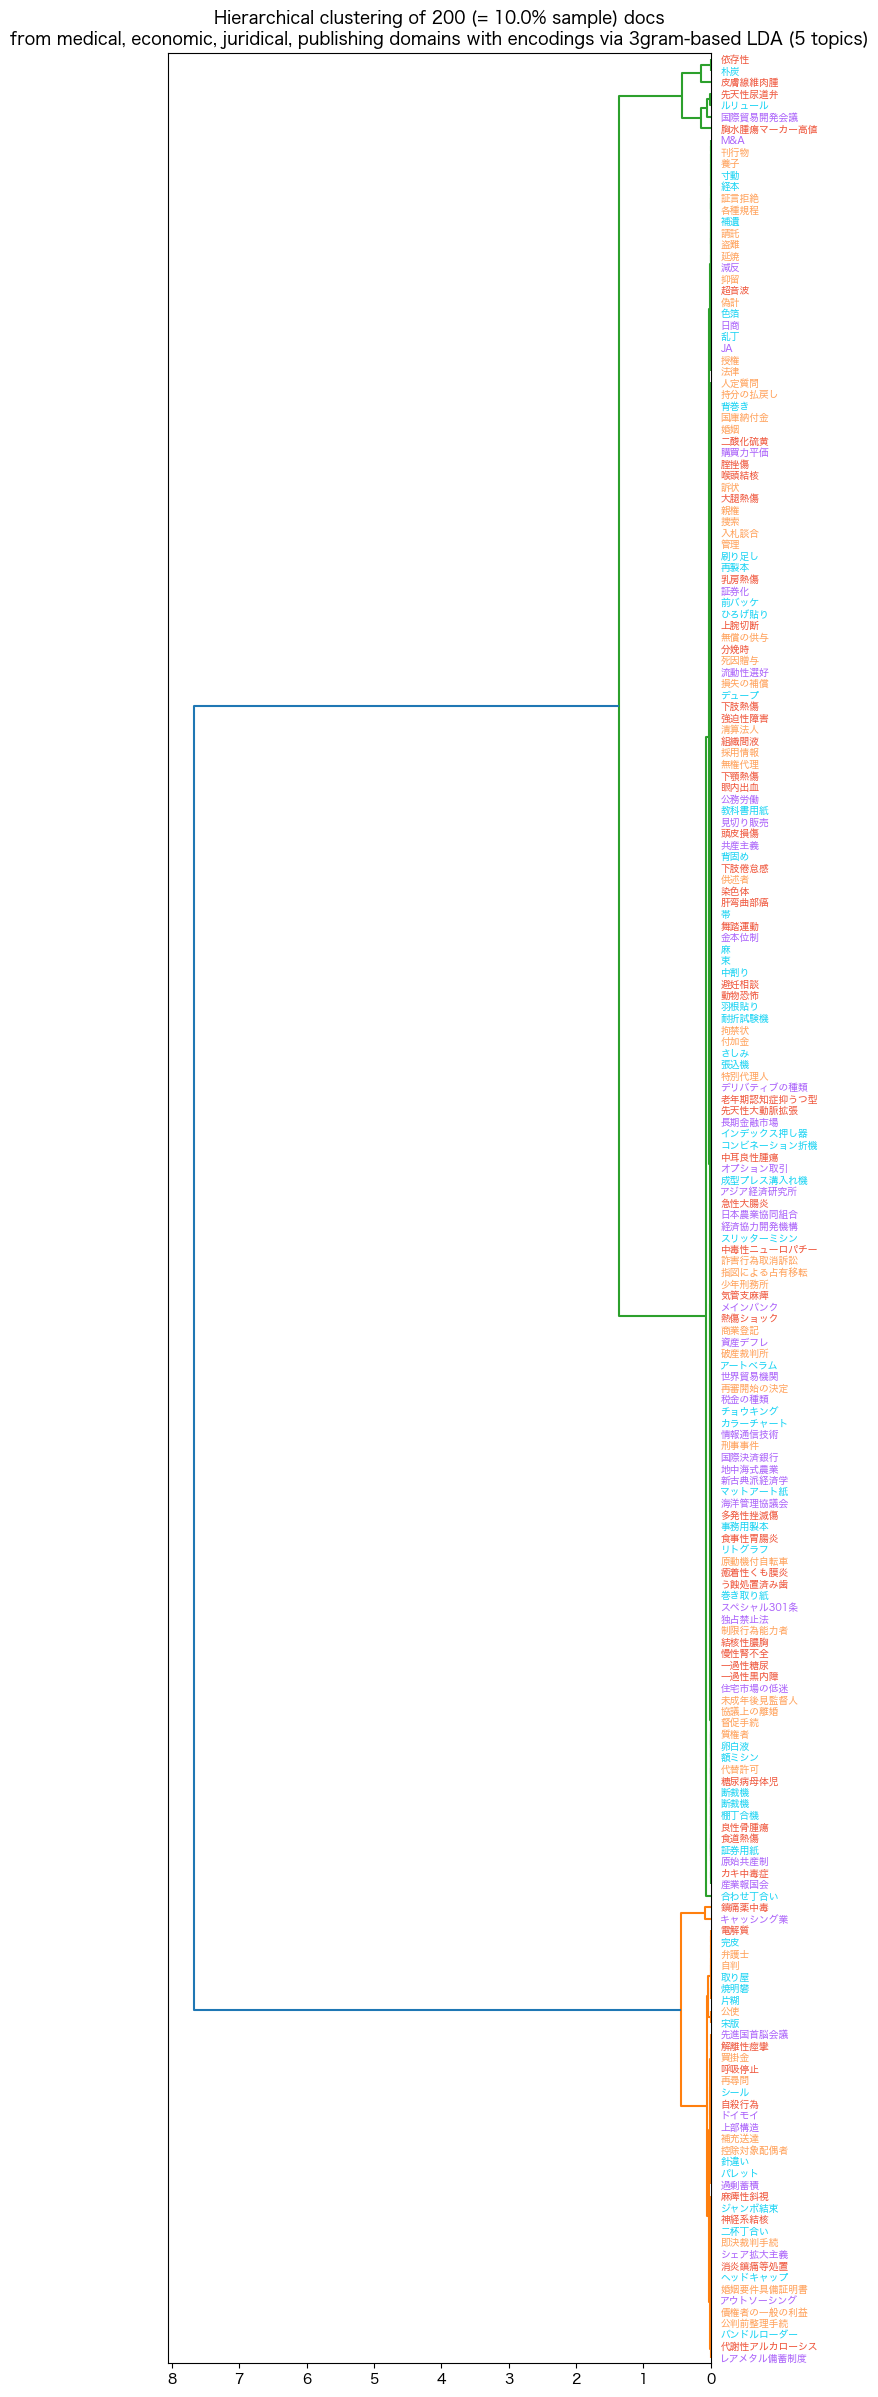

In [23]:
## doc 階層クラスタリングの実行

from scipy.cluster.hierarchy import dendrogram, linkage

## 距離行列の生成

## 生データから
doc_linkage_plain = linkage(list(df_sampled['enc']), method = 'ward', metric = 'euclidean')

import numpy as np
import plotly
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Hiragino sans" # 日本語表示のための設定

## 描画サイズの指定
plt.figure(figsize = (7, round(10 * len(df_sampled) * 0.015))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_vals = [ x[:max_doc_length] for x in list(df_sampled[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
dendrogram(doc_linkage_plain, orientation = 'left', labels = label_vals, leaf_font_size = 7)
plt.title(f"Hierarchical clustering of {len(df_sampled)} (= {100 * hc_sampling_rate}% sample) docs\n\
from {', '.join(selected_domains.keys())} domains with encodings via {term_type}-based LDA ({n_topics} topics)")

## ラベルに domain に対応する色を付ける
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    word = ticker.get_text()
    row = df_sampled.loc[df_sampled[doc_type] == word]
    try:
        domain_id = int(row['domain_id'])
    except TypeError:
        pass
    ticker.set_color(plotly.colors.qualitative.Plotly[domain_id + 1]) # id の基数調整
#
plt.show()